# Training

In [1]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd

c:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import torch

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [4]:
#getting path for the dataset
path2 = os.path.join(os.getcwd(), "Logo_classif3")

In [5]:
#applying a transform on all images and building the dataset
transform = transforms.Compose([
transforms.Resize((128, 128)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)
])

logos = ImageFolder(path2, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


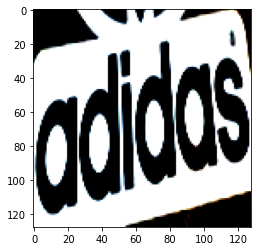

In [6]:
plt.imshow(logos[152][0].permute(1, 2, 0))

In [7]:
#checking length of dataset
len(logos)

4578

In [8]:
#checking how many classes are present in the dataset
len(logos.classes)

47

In [9]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

In [12]:
#create a dataset class
class Logos(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample = {"pic": self.X[index][0], "label": self.X[index][1]}
        return sample

In [13]:
full_data = Logos(logos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


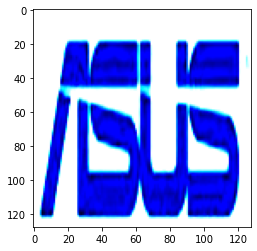

In [14]:
#checking if __getitem__() works
plt.imshow(full_data[0]["pic"].permute(1, 2, 0))

In [15]:
#calculating train and test size, train size is about 80% of the whole dataset
train_size = int(0.8*len(logos))
test_size = len(logos) - train_size
train_size, test_size

(3662, 916)

In [16]:
#splitting whole dataset into train and test
train_data, test_data = torch.utils.data.random_split(full_data, (train_size, test_size))

In [17]:
train_data = torch.utils.data.Subset(train_data, np.arange(train_size))

In [18]:
test_data = torch.utils.data.Subset(test_data, np.arange(test_size))

In [19]:
import torch.nn as nn

In [20]:
import torchvision

In [21]:
#printing model so I can look at the fc to get the in_features variable
torchvision.models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
#a function to modify the last layer of the model
def get_model(n_classes):
    model = torchvision.models.resnet18(pretrained=True)
    in_features = 512
    model.fc = nn.Linear(in_features=in_features, out_features=n_classes)
    return model

In [35]:
model = get_model(len(logos.classes)).to(device=device)
model.to(device=device)

#getting the model parameters that require grad to insert into the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

In [36]:
#creating a train- and test dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,
shuffle=True)

In [37]:
for i in range(10):
    print(train_data[-i]["label"])

31
14
43
31
22
33
31
11
31
34


In [38]:
len(train_loader)

58

In [39]:
len(test_loader)

15

In [40]:
n_epochs = 3

In [41]:
import datetime

In [42]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    #these arrays are just for plotting the accuracies and losses
    train_acc = np.zeros(n_epochs)
    test_acc = np.zeros(n_epochs)
    train_loss_list = np.zeros(n_epochs)
    test_loss_list = np.zeros(n_epochs)

    
    with torch.cuda.device(0):
        #train loop
        for epoch in range(n_epochs):
            model.train()
            #some dummy variables to calculate accuracies and losses
            loss_train = 0.0
            loss_test = 0.0
            total = 0
            correct = 0
            out_correct = 0
            
            for items in train_loader:
                outputs = model(items["pic"].to(device=device))
                loss = loss_fn(outputs, items["label"].to(device=device))

                optimizer.zero_grad()

                loss.backward()
                
                optimizer.step()

                loss_train += loss.item()

                #the prediction is the argument of the largest value in the output vector
                _, pred = torch.max(outputs, dim=1)
                correct += int((pred == items["label"].to(device=device)).sum())
            
            model.eval()
            #test loop
            with torch.no_grad():
                for sample in test_loader:
                    
                    train_out = model(sample["pic"].to(device=device))
                    out_loss = loss_fn(train_out, sample["label"].to(device=device))
                    
                    #the prediction is the argument of the largest value in the output vector
                    _, out_pred = torch.max(train_out, dim=1)
                    out_correct += int((out_pred == sample["label"].to(device=device)).sum())
                    loss_test += out_loss.item()
            
            #calculating accuracies and losses
            train_acc[epoch] = correct / len(train_data)
            test_acc[epoch] = out_correct / len(test_data)
            train_loss_list[epoch] = loss_train / len(train_loader)
            test_loss_list[epoch] = loss_test / len(train_loader)
            
            #this prints every epochs if the model went through less than 10 epochs
            #otherwise it prints every 10 epochs
            if epoch < 10 or (epoch) % 10 == 0:
                print("-----------------------------------------------------")
                print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, train_loss_list[epoch]))
                print('Training accuracy: {}'.format(train_acc[epoch]))
                print('Test loss: {}'.format(test_loss_list[epoch]))
                print('Test accuracy {}'.format(test_acc[epoch]))
    
    #plotting train and test accuracy at each epoch
    plt.plot(np.arange(n_epochs), train_acc)
    plt.plot(np.arange(n_epochs), test_acc)

In [43]:
loss_fn = nn.CrossEntropyLoss()

In [44]:
#just checking if model outputs a vector of necessary length
model(train_data[0]["pic"].unsqueeze(0).to(device=device))

tensor([[ 0.5319, -0.0104,  0.3395, -0.1099, -0.6297, -0.6940, -0.5038,  0.1098,
         -0.4950,  0.2428, -0.0128, -0.5626, -0.7248,  1.3925,  0.5429, -0.8027,
         -1.0126, -0.0784,  0.9176, -0.6154, -1.2215,  1.0176, -0.1660,  0.6377,
         -0.4601, -0.2978, -1.4965, -0.7748,  0.8392, -0.0914, -0.3683,  0.6715,
         -0.6881, -0.5349, -0.3217, -0.2364,  0.9481, -0.0849, -0.4374, -0.5889,
          0.5013,  0.0138,  0.9833,  1.2125,  0.4377,  0.9700,  0.4830]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [45]:
model(train_data[0]["pic"].unsqueeze(0).to(device=device)).shape

torch.Size([1, 47])

-----------------------------------------------------
2021-09-23 19:36:12.088340 Epoch 0, Training loss 0.8981305329964079
Training accuracy: 0.7804478427089022
Test loss: 0.14153101552149344
Test accuracy 0.8700873362445415
-----------------------------------------------------
2021-09-23 19:36:28.177077 Epoch 1, Training loss 0.20631601147610565
Training accuracy: 0.9494811578372474
Test loss: 0.08618310521003501
Test accuracy 0.9115720524017468
-----------------------------------------------------
2021-09-23 19:36:44.326444 Epoch 2, Training loss 0.12765815433371683
Training accuracy: 0.9721463681048608
Test loss: 0.08448178757881296
Test accuracy 0.9203056768558951


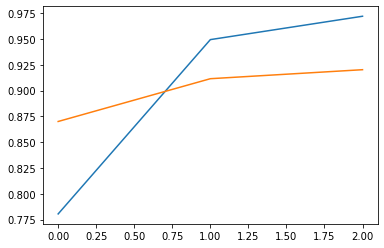

In [46]:
training_loop(
n_epochs = n_epochs,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

In [55]:
#creating a directory for the model to save in
os.mkdir('logos_model')

In [56]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), "logos_model\\logos_model.pth"))

In [57]:
loaded_model = get_model(n_classes=47).to(device=device)
loaded_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "logos_model\\logos_model.pth")))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


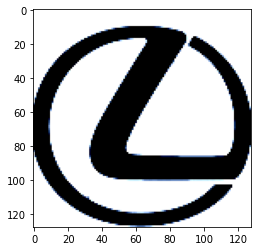

In [58]:
plt.imshow(test_data[i]["pic"].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


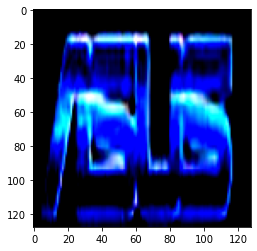

TypeError: list indices must be integers or slices, not numpy.float64

In [61]:
pred = np.zeros(len(test_data))
true = np.zeros(len(test_data))
correct = 0
loaded_model.eval()
#attempting a few predictions
#accuracy is very low
with torch.no_grad():
    for i in range(len(test_data)):
        out = loaded_model(test_data[i]["pic"].unsqueeze(0).to(device=device))
        pred[i] = torch.argmax(out)
        true[i] = test_data[i]["label"]
        if pred[i] == true[i]:
            correct += 1
        if i < 10:
            plt.imshow(test_data[i]["pic"].permute(1, 2, 0))
            plt.show()
            print(logos.classes[int(pred[i])]
print("Accuracy:", correct/len(test_data))

In [48]:
pred

array([ 0.,  0., 32., 25., 17.,  9., 20., 16.,  1., 20., 32.,  8., 32.,
       28., 26.,  0., 36., 25., 33., 42., 31., 34., 21., 39., 20.,  6.,
       30., 38., 34., 28., 38., 33., 44., 27., 37., 31.,  7., 31., 34.,
       43.,  5., 31., 46.,  2., 40., 28., 11., 31., 34., 34., 25., 35.,
       16., 31., 10., 23., 25., 20., 31., 44., 12., 46., 45.,  5., 39.,
       18., 31., 31., 31.,  5., 34., 25., 35., 43., 31.,  2., 21., 42.,
       25., 34., 34., 45., 11., 28., 10.,  5., 31., 34., 26., 46., 19.,
       32., 19., 43., 31., 46.,  2., 17., 28.,  0., 28.,  0., 21., 22.,
       41.,  3., 25., 34., 31., 28., 33., 42.,  1., 36.,  8., 16., 46.,
       15., 34., 35., 28., 41., 18., 18., 24., 17., 33., 20., 40., 31.,
       43., 14., 27., 40.,  8., 23., 36., 10., 18., 43., 15., 28., 34.,
       25., 17.,  1., 25.,  3., 36., 27., 15.,  8., 16., 18.,  8., 29.,
       28., 32., 12., 28., 31.,  3., 43.,  6., 35., 25., 17.,  8., 23.,
        0., 35.,  5.,  7., 18., 35., 33., 25., 35., 21.,  4., 42

In [49]:
true

array([ 0.,  0., 32., 25., 17.,  9., 20., 16., 11., 20., 32.,  8., 32.,
       28., 26.,  0., 11., 25., 33., 42.,  4., 34., 21., 36., 20.,  6.,
       30., 38., 34., 28., 38., 33., 44., 27., 37., 31., 19., 31., 34.,
       43.,  5., 31., 46.,  0., 40., 28., 22., 31., 34., 34., 25., 29.,
       18., 31., 10., 23., 25.,  5., 31., 44., 12., 46., 45.,  5., 39.,
       18.,  0., 31., 31.,  5., 34., 25., 35., 43., 31.,  2., 21., 42.,
       25., 34., 34., 45., 11., 28., 10.,  5., 31., 34.,  4., 46., 19.,
       32., 19., 43., 31., 46.,  2., 17., 28.,  0., 22.,  0., 21., 22.,
       41.,  3., 25., 34., 31., 28., 33., 42.,  1., 25.,  8., 16., 46.,
       15., 34., 35., 28., 41., 18., 18., 22., 17., 33., 20., 40., 31.,
       43., 14., 27., 40.,  8., 23., 11., 10., 18., 43., 15., 25., 34.,
       25., 17.,  1., 25.,  3., 36., 27., 15.,  8., 16., 18.,  8., 29.,
       28., 32., 12., 28., 31.,  3., 43.,  6., 41., 25., 17.,  8., 23.,
        0., 15.,  5.,  7., 18., 18., 33., 25., 35., 21.,  4., 42

In [50]:
len(test_data)

916

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [52]:
#create a confusion matrix from above predictions
cm = confusion_matrix(true, pred)

In [53]:
#create an object that allows me to display the above matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = logos.classes)

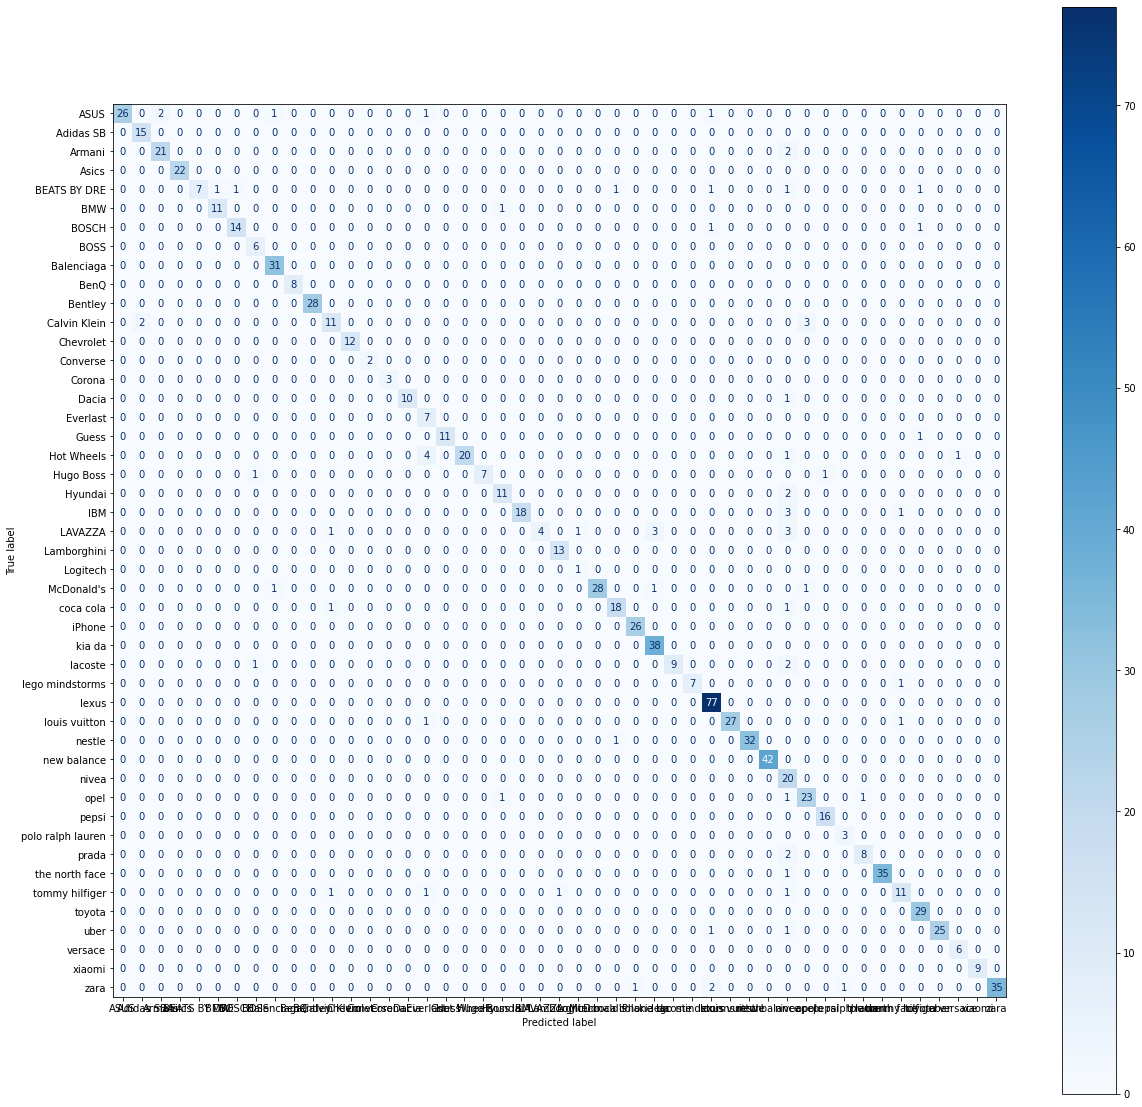

In [54]:
#displaying the confusion matrix
disp = disp.plot(cmap = "Blues", ax=plt.subplots(figsize=(20, 20))[1]) 